MNIST Classifier using GPU acceleration. This model uses 6 fully connected layers and was made to mimmic a design that I found online.

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline
import numpy as np
np.set_printoptions(suppress=True)

batch_size = 128

train = datasets.MNIST('', train=True, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

test  = datasets.MNIST('', train=False, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))
trainset = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
testset  = torch.utils.data.DataLoader(test,  batch_size=batch_size, shuffle=True)

In [2]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 2500)
        self.fc2 = nn.Linear(2500, 2000)
        self.fc3 = nn.Linear(2000, 1500)
        self.fc4 = nn.Linear(1500, 1000)
        self.fc5 = nn.Linear(1000, 500)
        self.fc6 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return F.log_softmax(x, dim=1)

In [3]:
def train(model, epochs):
    accuracies, losses = [], []
    optimiser = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(epochs):
        for data in tqdm(trainset):
            X, y = data
            X, y = X.cuda(), y.cuda()
            model.zero_grad()
            output = model(X.view(-1, 784))
            loss = F.nll_loss(output, y)
            losses.append(loss)
            preds = [torch.argmax(out) for out in output]
            acc = np.array([(int(a) == int(b)) for a, b in zip(preds, y)]).mean()
            accuracies.append(acc)
            loss.backward()
            optimiser.step()
    return losses, accuracies

In [5]:
model = Net().cuda()
losses, accuracies = train(model, 3)

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:19<00:00, 24.55it/s]


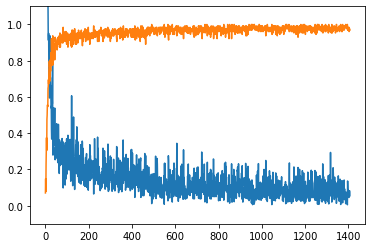

In [6]:
plt.ylim(-0.1, 1.1)
plt.plot(losses)
plt.plot(accuracies)

In [111]:
print(f'Loss :: {losses[-1]} Accuracy :: {accuracies[-1]}')

Loss :: 0.018678518012166023 Accuracy :: 0.9895833333333334


In [112]:
def test(model):
    losses, accuracies = [], []
    for data in tqdm(testset):
        X, y = data
        X, y = X.cuda(), y.cuda()
        out = model(X.view(-1, 784))
        loss = F.nll_loss(out, y)
        preds = [torch.argmax(i) for i in out]
        acc = np.array([ (int(a) == int(b)) for a, b in zip(preds, y) ]).mean()
        losses.append(loss)
        accuracies.append(acc)
    return losses, accuracies

In [113]:
loss, acc = test(model)

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 24.44it/s]


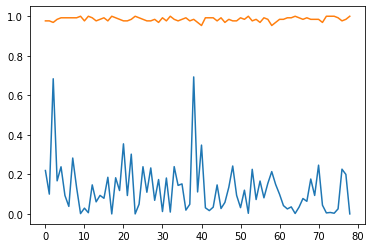

In [114]:
plt.plot(loss)
plt.plot(acc)

In [115]:
print(f'Loss :: {sum(loss)/len(loss)} Accuracy :: {sum(acc)/len(acc)}')

Loss :: 0.12474378198385239 Accuracy :: 0.9848694620253164
